# This script contains the following:

### 1. Importing your libraries and data
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time series analysis: decomposition
### 4. Testing for stationarity
### 5. Stationarizing the Data

## 1. Importing libraries and data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [4]:
# Set path
path = r'/Users/asadagha/Documents/CF Data Analytics/Data Analytics Immersion/Achievement 6/Ex 6.6'

# Importing Zillow Real Estate Data
data = pd.read_csv(os.path.join(path, 'ZILLOW_DATA.csv'))
regions = pd.read_csv(os.path.join(path, 'ZILLOW_REGIONS.csv'))

In [5]:
data.head()

indicator_id  region_id        date          value
0         Z4BR      65856  2018-02-28  509966.717868
1         Z4BR      94920  2018-02-28  393052.284119
2         Z4BR      63078  2018-02-28   89932.390841
3         Z4BR      73108  2018-02-28  219385.968716
4         Z4BR      77740  2018-02-28  218395.779920

In [6]:
data.shape

(155574532, 4)

In [7]:
regions.head()

region_id region_type           region
0     394415       metro   Bridgeport, CT
1     394653       metro   Greenville, SC
2     394312       metro  Albuquerque, NM
3     394357       metro  Bakersfield, CA
4     394308       metro       Albany, NY

## 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Create a subset from region data filtered to only show regions based on zip code
regions_zip = regions.loc[(regions['region_type'] == 'zip')]

In [10]:
# ZIP Code Lists by County

# Harris County (Houston core)
harris = [
  77001, 77002, 77003, 77004, 77005, 77006, 77007, 77008, 77009, 77010, 77011, 77012, 77013,
  77014, 77015, 77016, 77017, 77018, 77019, 77020, 77021, 77022, 77023, 77024, 77025, 77026,
  77027, 77028, 77029, 77030, 77031, 77032, 77033, 77034, 77035, 77036, 77037, 77038, 77039,
  77040, 77041, 77042, 77043, 77044, 77045, 77046, 77047, 77048, 77049, 77050, 77051, 77054,
  77055, 77056, 77057, 77058, 77059, 77060, 77061, 77062, 77063, 77064, 77065, 77066, 77067,
  77068, 77069, 77070, 77071, 77072, 77073, 77074, 77075, 77076, 77077, 77078, 77079, 77080,
  77081, 77082, 77083, 77084, 77085, 77086, 77087, 77088, 77089, 77090, 77091, 77092, 77093,
  77094, 77095, 77096, 77098, 77099, 77201, 77202, 77203, 77204, 77205, 77206, 77207, 77208,
  77209, 77210, 77212, 77216, 77219, 77221, 77223, 77224, 77225, 77226, 77230, 77233, 77234,
  77235, 77237, 77238, 77240, 77244, 77248, 77249, 77250, 77251, 77252, 77253, 77254, 77255,
  77256, 77257, 77258, 77259, 77261, 77262, 77263, 77265, 77266, 77267, 77268, 77269, 77270,
  77271, 77272, 77273, 77274, 77277, 77279, 77282, 77284, 77287, 77288, 77289, 77290, 77291,
  77292, 77293, 77294, 77296, 77297, 77298, 77299
]

# Fort Bend County
fort_bend = [
  77406, 77407, 77450, 77459, 77469, 77477, 77478, 77479, 77489, 77494
]

# Montgomery County
montgomery = [
  77301, 77302, 77303, 77304, # Conroe area
  77316, 77356, # Montgomery
  77318, 77378, # Willis
  77354, 77355, # Magnolia
  77357, # New Caney
  77365, # Porter
  77372, # Splendora
  77380, 77381, 77382, 77384, 77385, 77386, 77389 # The Woodlands/Spring area (partial Montgomery)
]

# Galveston County
galveston = [
  77510, 77517, 77518, # Santa Fe, Bacliff
  77539, # Dickinson
  77546, # Friendswood (part Harris/Galveston)
  77550, 77551, 77552, 77553, 77554, # Galveston
  77563, # Hitchcock
  77565, # Kemah
  77568, # La Marque
  77573, # League City
  77590, 77591, 77592, # Texas City
  77598  # Clear Lake (part Harris/Galveston)
]

# Brazoria County
brazoria = [
  77422, # Sweeny
  77430, # Danciger
  77431, # Damon
  77511, # Alvin
  77515, # Angleton
  77531, # Clute
  77534, # Danbury
  77541, # Freeport
  77566, # Lake Jackson
  77577, # Liverpool
  77578, # Manvel
  77581, # Pearland
  77583, # Rosharon
  77584  # Pearland
]

# Chambers County
chambers = [
  77514, # Anahuac
  77523, # Mont Belvieu
  77520, 77521, 77522, # Baytown (partial Chambers/Harris)
  77597, # Winnie
  77560  # Hankamer
]

# Liberty County
liberty = [
  77535, # Dayton
  77575  # Liberty
]

# Waller County
waller = [
  77423, # Brookshire
  77445, # Hempstead
  77484, # Waller
  77485, # Pattison
  77466  # Prairie View
]

In [11]:
# Combine all ZIP codes into one list
zip_codes = harris + fort_bend + montgomery + galveston + brazoria + chambers + liberty + waller

In [12]:
# Extract ZIP code from the 'region' column
def extract_zip(region_str):
    first_part = region_str.split(';')[0]  
    if first_part.isdigit():
        return int(first_part)
    return None

regions_zip['zip_code'] = regions_zip['region'].apply(extract_zip)

In [13]:
# Filter by desired ZIP codes
filtered_zip = regions_zip[regions_zip['zip_code'].isin(zip_codes)]

In [14]:
filtered_zip.head()

region_id region_type  \
42511      92036         zip   
42536      91968         zip   
42570      92045         zip   
42624      91950         zip   
42641      91732         zip   

                                                  region  zip_code  
42511  77573;TX;Houston-The Woodlands-Sugar Land, TX;...     77573  
42536  77479;TX;Houston-The Woodlands-Sugar Land, TX;...     77479  
42570  77584;TX;Houston-The Woodlands-Sugar Land, TX;...     77584  
42624  77459;TX;Houston-The Woodlands-Sugar Land, TX;...     77459  
42641  77083;TX;Houston-The Woodlands-Sugar Land, TX;...     77083

In [15]:
# Merge the filtered zip dataframe onto the main data
df_merged = data.merge(filtered_zip, on='region_id', how='inner')

In [16]:
df_merged.head()

indicator_id  region_id        date          value region_type  \
0         Z4BR      92024  2018-02-28  521869.014646         zip   
1         Z4BR      92024  2018-03-31  521935.732819         zip   
2         Z4BR      92024  2018-04-30  522151.499856         zip   
3         Z4BR      92024  2018-05-31  524425.059534         zip   
4         Z4BR      92024  2018-06-30  527388.313009         zip   

                                              region  zip_code  
0  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
1  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
2  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
3  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
4  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554

In [17]:
# Subset only to 'ZALL' indicator - house price for All Homes
df_merged2 = df_merged.loc[(df_merged['indicator_id'] == 'ZALL')]

In [18]:
df_merged2.head()

indicator_id  region_id        date     value region_type  \
139         ZALL      92024  1997-03-31  186064.0         zip   
140         ZALL      92024  1997-04-30  183650.0         zip   
141         ZALL      92024  1997-05-31  181324.0         zip   
142         ZALL      92024  1997-06-30  177620.0         zip   
143         ZALL      92024  1997-07-31  175024.0         zip   

                                                region  zip_code  
139  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
140  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
141  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
142  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554  
143  77554;TX;Houston-The Woodlands-Sugar Land, TX;...     77554

## 2.2 Data Cleaning

In [20]:
df_merged2.dtypes

indicator_id     object
region_id         int64
date             object
value           float64
region_type      object
region           object
zip_code          int64
dtype: object

In [21]:
# Convert 'date' to datetime
df_merged2['date'] = pd.to_datetime(df_merged2['date'])

In [22]:
# Check for duplicates
dups = df_merged2[df_merged2.duplicated()]

In [23]:
print(dups)

Empty DataFrame
Columns: [indicator_id, region_id, date, value, region_type, region, zip_code]
Index: []


In [24]:
# Check for missing values
df_merged2.isnull().sum()

indicator_id    0
region_id       0
date            0
value           0
region_type     0
region          0
zip_code        0
dtype: int64

No Missing values found

In [26]:
# Mixed-type check
for col in ['region_id', 'value', 'zip_code']:
    unique_types = df_merged2[col].map(type).nunique()
    if unique_types > 1:
        print(f"Column '{col}' has mixed types.")
    else:
        print(f"Column '{col}' has a consistent type.")

Column 'region_id' has a consistent type.
Column 'value' has a consistent type.
Column 'zip_code' has a consistent type.


In [27]:
# Group by 'date' and take average value
prices = df_merged2.groupby('date')['value'].mean().reset_index()

from datetime import datetime

prices['datetime'] = pd.to_datetime(prices['date'])
prices = prices.set_index('datetime')
prices.drop(['date'], axis=1, inplace=True)

In [28]:
prices.head()

value
datetime                 
1996-01-31  120519.068702
1996-02-29  121793.636364
1996-03-31  121841.742424
1996-04-30  121982.484848
1996-05-31  122082.128788

In [29]:
prices.describe()

value
count     343.000000
mean   185593.304143
std     59244.451150
min    120519.068702
25%    140452.204904
50%    160508.904127
75%    224155.572075
max    328369.016997

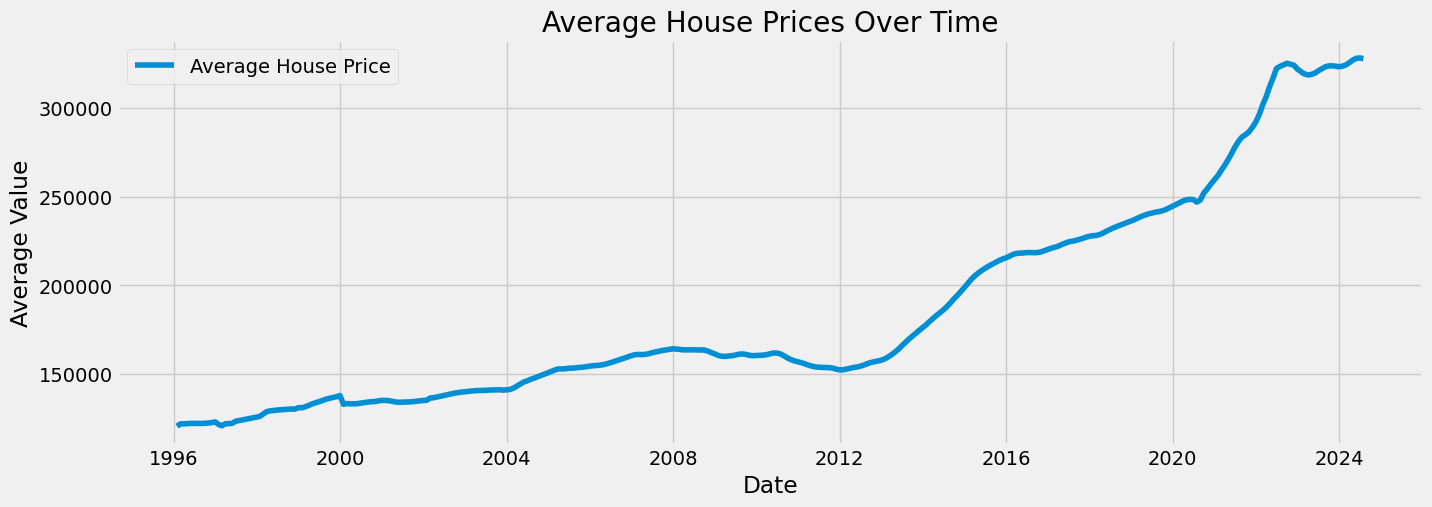

In [30]:
# Plot the data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(prices, label='Average House Price')
plt.title('Average House Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.legend()
plt.show()

The line chart shows a steady increase in home prices throughout the dataset. This upward trend suggests that house prices have generally grown over the observed period, likely influenced by regional economic growth, demand for housing, and other economic factors.

## 3. Time-series analysis: decomposition

In [32]:
decomposition = sm.tsa.seasonal_decompose(prices, model='additive')

In [33]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,7

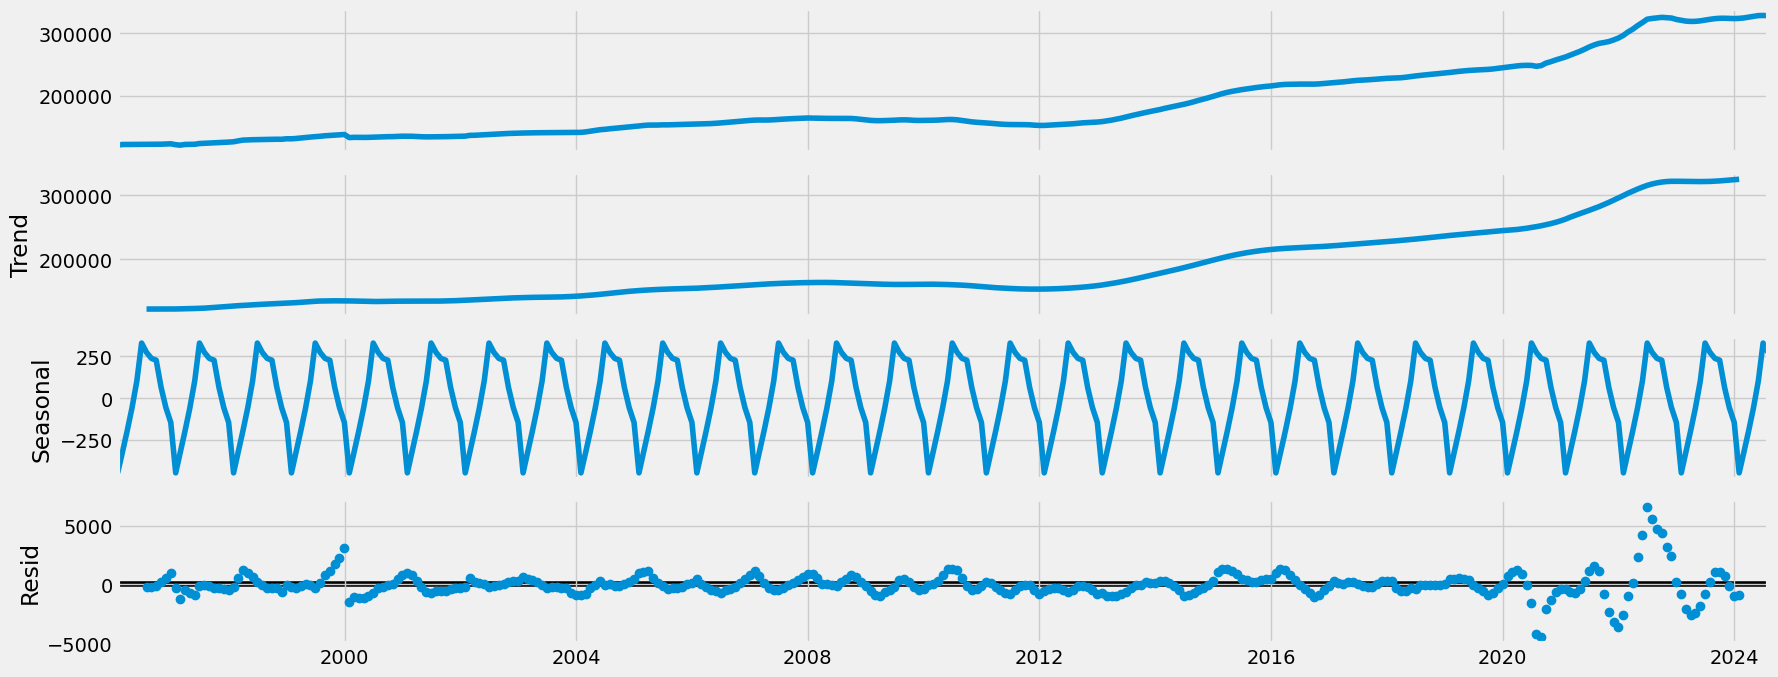

In [34]:
decomposition.plot()
plt.show()

The decomposition plot shows the following:  
- **Observed (Level):** The raw data series steadily increases over time.  
- **Trend:** A clear upward trend is visible, indicating that over the long term, house prices in the region have been rising.  
- **Seasonal:** There is a pronounced seasonal pattern, with recurring peaks and troughs at regular intervals.
- **Residual (Noise):** The residual component is relatively small but shows some variance. This residual variance may represent short-term, irregular fluctuations in the market.

## 4. Testing for stationarity

In [66]:
# Conduct a Dickey-Fuller test to check for stationarity
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    print('Dickey-Fuller Stationarity Test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], 
                       index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    print(result)

In [68]:
# Apply the test on the time series
dickey_fuller(prices['value'])

Dickey-Fuller Stationarity Test:
Test Statistic            1.154321
p-value                   0.995655
# Lags Used               2.000000
# Observations Used     340.000000
Critical Value (1%)      -3.449730
Critical Value (5%)      -2.870079
Critical Value (10%)     -2.571319
dtype: float64


- **Null Hypothesis (H₀):** The series is non-stationary and has a unit root.  
- **Alternative Hypothesis (H₁):** The series is stationary.

From the initial test on the original data:  
- The **test statistic** (1.154321) is **greater than** all the critical values (-3.449 at 1%, -2.870 at 5%, and -2.571 at 10%).  
- The **p-value** (0.995655) is significantly greater than 0.05.

Since the test statistic is not negative enough to fall below the critical values and the p-value is much larger than 0.05, we **fail to reject the null hypothesis**. This confirms that the data is **non-stationary**. This result aligns with the observed upward trend and seasonal fluctuations in the line chart and decomposition plots.

## 5. Stationarizing the Data

In [72]:
# Differencing to make the series stationary
data_diff = prices - prices.shift(1)
data_diff.dropna(inplace=True)

In [74]:
data_diff.head()

value
datetime               
1996-02-29  1274.567661
1996-03-31    48.106061
1996-04-30   140.742424
1996-05-31    99.643939
1996-06-30   -21.113636

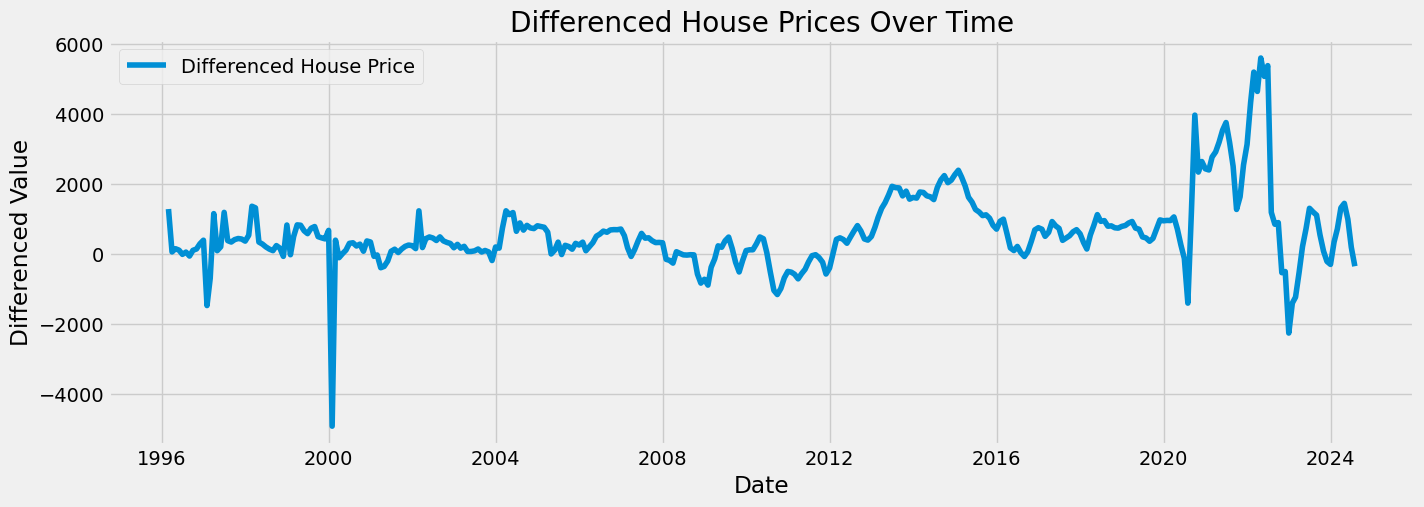

In [76]:
# Plot differenced data
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff, label='Differenced House Price')
plt.title('Differenced House Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()

In [78]:
# Check stationarity again
dickey_fuller(data_diff['value'])

Dickey-Fuller Stationarity Test:
Test Statistic           -4.707595
p-value                   0.000081
# Lags Used               1.000000
# Observations Used     340.000000
Critical Value (1%)      -3.449730
Critical Value (5%)      -2.870079
Critical Value (10%)     -2.571319
dtype: float64


The p-value is now below 0.05, and the test statistic is more negative than the critical values. We reject the null hypothesis, confirming the series is now stationary and suitable for time series modeling.

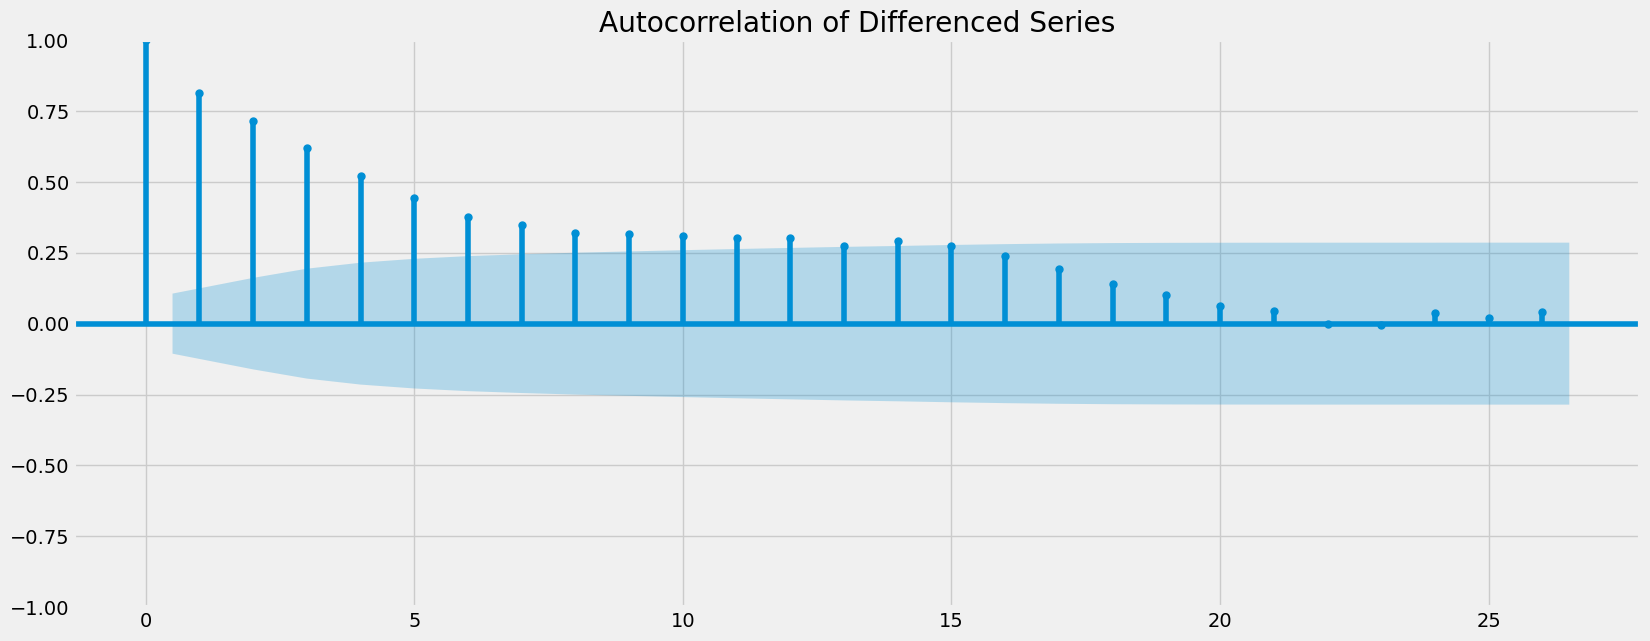

In [80]:
# Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_diff)
plt.title('Autocorrelation of Differenced Series')
plt.show()